In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [16]:
def plot_top_10(results_top_10, results, model):
    top_10_ids = results_top_10['timestamp'].values
    fig, axs = plt.subplots(figsize=(7, 6))
    for exp_id in top_10_ids:
        if exp_id == top_10_ids[0]:
            print('Best Run:\n', results_top_10[results_top_10['timestamp']==exp_id])
            alpha = 1
            width = 3
            marker = 'o'
        else:
            alpha = 0.5
            width = 1
            marker = None

        exp_results = results[results['timestamp']==exp_id]
        h_dim, lr, n_layers = exp_results[['hidden_dim', 'learning_rate', 'n_layers']].iloc[0,:].values
        label = f'h_dim={int(h_dim)}, lr={lr}, h_layers={int(n_layers)}'

        axs.plot(exp_results['epoch'], exp_results['val_acc'], label=label, linewidth=width, alpha=alpha, marker=marker)

    axs.legend(loc='lower right')

    axs.set_title(f'{model} tuning results (top 10 runs)')
    axs.set_ylabel('validation accuracy')
    axs.set_xlabel('epoch')

    plt.show()


def get_top_epochs(results):
    top_epochs = pd.DataFrame()
    exp_ids = results['timestamp'].unique()
    for exp_id in exp_ids:
        exp_results = results[results['timestamp']==exp_id]
        top_epoch = exp_results[exp_results['val_acc']==exp_results['val_acc'].max()].head(1)
        top_epochs = pd.concat((top_epochs, top_epoch), ignore_index=True)
    top_epochs.rename(columns={'epoch': 'best_epoch'})
    top_epochs.sort_values(by='val_acc', inplace=True, ascending=False)
    return top_epochs


def analyze_tuning_experiments(model, results):
    results = results[results['model']==model]
    print('Model:', model)
    top_epochs = get_top_epochs(results)
    results_top_10 = top_epochs.head(10)
    plot_top_10(results_top_10, results, model)


def analyze_n_sample_experiments(results):
    top_epochs = get_top_epochs(results)
    top_epochs.sort_values(by=['model', 'n_samples'], inplace=True)
    linestyles = {'bert': 'dotted', 'simcse': 'solid'}
    markers = {'bert': 'x', 'simcse': 'D'}
    
    for model in ['bert', 'simcse']:
        top_epochs_model = top_epochs[top_epochs['model']==model]
        top_epochs_model = top_epochs_model.groupby('n_samples', as_index=False).agg(mean_val_acc=('val_acc', 'mean'), std_val_acc=('val_acc', 'std'))
        print(top_epochs_model.max())
        plt.errorbar(top_epochs_model['n_samples'], top_epochs_model['mean_val_acc'], yerr=top_epochs_model['std_val_acc'], marker=markers[model], label=model, linestyle=linestyles[model], color='black')
    
    plt.xlabel('Dataset size')

    plt.ylabel('Holdout Accuracy')
    plt.title('Training Size Sensitivity Analysis')
    plt.legend(loc='lower right')

    plt.show()

def analyze_permutation_experiments(results):
    fig, axs = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
    for model_permuted in ['BERT', 'SimCSE']:
        if model_permuted == 'BERT':
            model_results = results[results['model']=='SIMCSE']
        else:
            model_results = results[results['model']=='BERT']

        linestyles = {'SimCSE': 'dotted', 'BERT': 'solid'}
        markers = {'SimCSE': 'x', 'BERT': 'D'}
        axs[0].plot(model_results['epoch'], model_results['val_loss'], label=f'{model_permuted} embeddings permuted', 
                    linestyle=linestyles[model_permuted], marker=markers[model_permuted], color='black')
        axs[1].plot(model_results['epoch'], model_results['val_acc'], label=f'{model_permuted} embeddings permuted', 
                    linestyle=linestyles[model_permuted], marker=markers[model_permuted], color='black')
    
    axs[0].set_title('Validation results after permuting embeddings')
    axs[0].set_ylabel('validation loss')
    axs[0].legend()
    axs[1].set_ylabel('validation accuracy')
    axs[1].legend()
    axs[1].set_xlabel('epoch')
    

    plt.show()

    



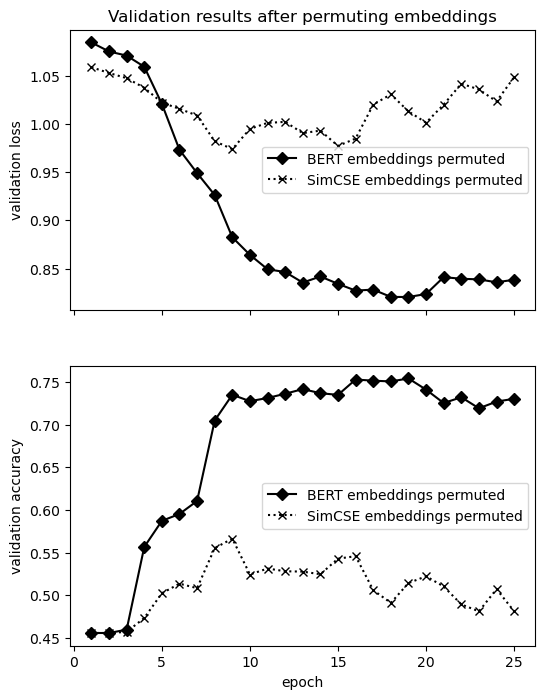

In [17]:
permute_results = pd.read_csv('ext2.csv')
analyze_permutation_experiments(permute_results)

n_samples       10000.000000
mean_val_acc        0.744347
std_val_acc         0.049551
dtype: float64
n_samples       10000.000000
mean_val_acc        0.875995
std_val_acc         0.045931
dtype: float64


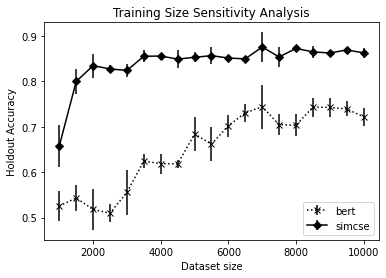

In [29]:
n_sample_results = pd.read_csv('n_sample_experiment_results.csv')
analyze_n_sample_experiments(n_sample_results)

Model: simcse
Best Run:
     epoch  train_loss  val_loss   val_acc  hidden_dim  learning_rate  \
36     23    0.633621  0.662533  0.888278         512         0.0005   

    num_epochs  batch_size  n_layers   model  input_dim   timestamp  
36          25        1024         1  simcse        768  1670026763  


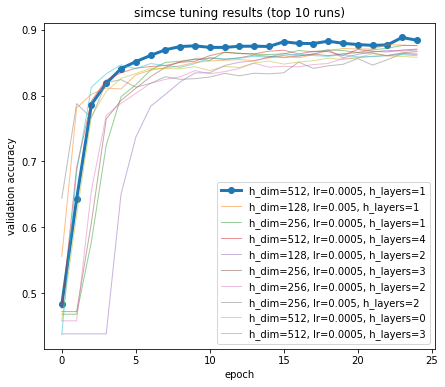

Model: bert
Best Run:
     epoch  train_loss  val_loss  val_acc  hidden_dim  learning_rate  \
22     24    0.795471  0.779564  0.77027         256         0.0005   

    num_epochs  batch_size  n_layers model  input_dim   timestamp  
22          25        1024         2  bert        768  1670028149  


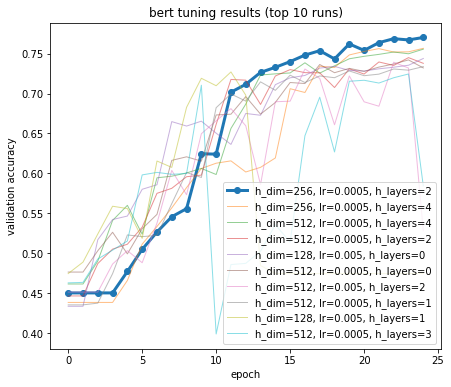

In [23]:
tuning_results = pd.read_csv('experiment_results.csv')

analyze_tuning_experiments('simcse', tuning_results)
analyze_tuning_experiments('bert', tuning_results)
